# 03_特征分析与可视化 - GLP-1临床试验风险预测

## 📊 功能概述

本notebook实现特征分析与可视化功能，对构建的18个临床特征进行深入分析：

1. **特征统计摘要** - 计算每个特征的描述性统计
2. **特征分布可视化** - 展示特征的分布情况
3. **特征相关性分析** - 分析特征之间的相关性关系
4. **特征质量评估** - 评估特征的质量和可用性
5. **数据质量报告** - 生成完整的数据质量报告

## 🚀 运行说明

直接运行所有单元格即可完成特征分析。

**输入文件**: `../processed_data/glp1_18clinical_features.csv`  
**输出文件**: 
- `../results/analysis_features.csv` - 分析用特征数据
- `../results/feature_statistics.csv` - 特征统计摘要
- `../results/feature_quality_report.csv` - 特征质量报告

**注意**: 所有图表将直接在notebook中显示，无需保存到外部文件

## 📝 学习目标

通过本notebook，您将学习：
- 如何对特征进行全面的统计分析
- 特征可视化的常用方法和技巧
- 特征相关性的分析和解释
- 数据质量评估的标准和方法

## 🎯 分析重点

本分析将重点关注以下方面：
- 特征的分布特征和异常值检测
- 特征之间的相关性关系
- 特征的质量和可用性评估
- 为后续建模提供数据准备

## 1. 导入必要的库

**📝 讲解**: 特征分析需要多种数据分析和可视化库的支持：

- **pandas**: 数据框操作和统计分析
- **numpy**: 数值计算和数学运算
- **matplotlib**: 数据可视化
- **seaborn**: 统计可视化
- **scipy**: 统计检验和科学计算
- **os**: 文件路径操作
- **sys**: 系统路径管理

**💡 技术要点**: 
- 设置中文字体确保图表正确显示中文
- 设置图表风格提高可视化效果
- 添加项目路径确保模块导入正确

In [29]:
# 导入特征分析所需的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import seaborn as sns
from scipy import stats
import os
import sys
from datetime import datetime
import matplotlib.font_manager as fm  # 用于动态检测中文字体

# ========== 中文字体配置（增强版）==========
print("🔧 设置中文字体配置...")

# 常见中文字体名称列表（涵盖 Windows、macOS、Linux）
chinese_font_names = [
    'SimHei', 'Microsoft YaHei',          # Windows
    'PingFang SC', 'STHeiti',              # macOS
    'WenQuanYi Zen Hei', '文泉驿正黑',      # Linux
    'Noto Sans CJK SC', 'Droid Sans Fallback'
]

# 获取当前系统中所有可用字体名称
available_fonts = [f.name for f in fm.fontManager.ttflist]

# 找出第一个可用的中文字体
selected_font = None
for font in chinese_font_names:
    if font in available_fonts:
        selected_font = font
        break

if selected_font is None:
    print("⚠️ 未找到已知中文字体，中文可能无法正确显示，将使用系统默认 sans-serif 字体。")
    selected_font = 'sans-serif'
else:
    print(f"✅ 找到可用中文字体: {selected_font}")

# 设置 matplotlib 参数
plt.rcParams['font.sans-serif'] = [selected_font] + plt.rcParams['font.sans-serif']
plt.rcParams['axes.unicode_minus'] = False

# 设置图表风格
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8')

# 再次确认字体设置（防止风格覆盖）
plt.rcParams['font.sans-serif'] = [selected_font] + [f for f in plt.rcParams['font.sans-serif'] if f != selected_font]
plt.rcParams['axes.unicode_minus'] = False

print("✅ 字体配置完成")
print(f"📋 最终字体列表: {plt.rcParams['font.sans-serif']}")
print(f"📋 负号显示: {plt.rcParams['axes.unicode_minus']}")
# ==========================================

# 忽略所有警告
warnings.filterwarnings('ignore', category=UserWarning)

# 添加项目根目录到路径，确保可以导入项目中的其他模块
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

# 特征名称到中文的映射字典
feature_name_mapping = {
    # 基础特征
    'nct_id': '临床试验ID',
    'enrollment_log': '入组人数对数',
    'start_year': '开始年份',
    
    # 时代特征
    'pre_semaglutide_era': '前司美格鲁肽时代',
    'post_semaglutide_era': '后司美格鲁肽时代',
    
    # 试验阶段特征
    'phase_Unknown': '未知阶段',
    'phase_PHASE4': '第四阶段',
    
    # 疾病特征
    'is_obesity': '肥胖相关',
    'is_t2d': '2型糖尿病相关',
    'is_weight_loss': '减重相关',
    
    # 入排标准特征
    'exc_count': '排除标准数量',
    'criteria_total_len': '入排标准总长度',
    'mentions_bmi': '提及BMI',
    'mentions_contraindication': '提及禁忌症',
    'mentions_renal_cutoff': '提及肾功能阈值',
    
    # 风险特征
    'high_risk_term_count': '高风险术语数量',
    'risk_ratio': '风险比率',
    
    # 交互特征
    'year_x_enrollment': '年份×入组人数',
    'enrollment_log_x_phase_Unknown': '入组对数×未知阶段'
}

def translate_feature_name(feature_name):
    """将特征名称翻译为中文"""
    return feature_name_mapping.get(feature_name, feature_name)

print(f"✅ 库导入完成")
print(f"当前工作目录: {os.getcwd()}")
print(f"Pandas版本: {pd.__version__}")
print(f"NumPy版本: {np.__version__}")
print(f"Seaborn版本: {sns.__version__}")
print(f"处理开始时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🔧 设置中文字体配置...
✅ 找到可用中文字体: SimHei
✅ 字体配置完成
📋 最终字体列表: ['SimHei', 'Arial', 'Liberation Sans', 'DejaVu Sans', 'Bitstream Vera Sans', 'sans-serif']
📋 负号显示: False
✅ 库导入完成
当前工作目录: d:\projects\glp1-trial-risk-prediction\glp1-risk-prediction\notebooks
Pandas版本: 2.3.3
NumPy版本: 2.2.6
Seaborn版本: 0.13.2
处理开始时间: 2026-02-27 13:10:43


## 2. 加载特征数据

**📝 讲解**: 加载由特征工程脚本生成的特征数据：

- 检查特征数据文件是否存在
- 加载数据并进行基本的数据质量检查
- 显示数据的基本信息和统计

**💡 技术要点**: 
- 使用`os.path.exists()`检查文件存在性
- 使用`pd.read_csv()`加载CSV文件
- 使用`info()`和`describe()`快速了解数据概况

In [30]:
# 检查特征数据文件是否存在
feature_file = '../processed_data/glp1_18clinical_features.csv'

if os.path.exists(feature_file):
    print(f"✅ 特征数据文件存在: {feature_file}")
    print(f"📏 文件大小: {os.path.getsize(feature_file)} 字节")
else:
    print(f"❌ 特征数据文件不存在: {feature_file}")
    print("💡 请先运行特征工程脚本生成特征数据")
    sys.exit(1)

# 加载特征数据
print("\n📥 加载特征数据...")
df = pd.read_csv(feature_file)

# 显示数据基本信息
print(f"📊 数据形状: {df.shape}")
print(f"📋 特征数量: {df.shape[1]}")
print(f"👥 样本数量: {df.shape[0]}")

# 显示前几行数据
print("\n📋 数据预览:")
display(df.head())

# 显示数据信息
print("\n📝 数据信息:")
df.info()

✅ 特征数据文件存在: ../processed_data/glp1_18clinical_features.csv
📏 文件大小: 2767103 字节

📥 加载特征数据...
📊 数据形状: (30105, 19)
📋 特征数量: 19
👥 样本数量: 30105

📋 数据预览:


,nct_id,enrollment_log,start_year,pre_semaglutide_era,post_semaglutide_era,phase_Unknown,phase_PHASE4,is_obesity,is_t2d,is_weight_loss,exc_count,criteria_total_len,mentions_bmi,mentions_contraindication,mentions_renal_cutoff,high_risk_term_count,risk_ratio,year_x_enrollment,enrollment_log_x_phase_Unknown
0,NCT00438555,5.517453,2006.0,1,0,0,0,1,0,0,0,234,1,0,0,0,0.0,11068.010510,0.0
1,NCT04272073,5.484797,2022.0,0,1,0,0,1,0,0,0,697,0,0,0,0,0.0,11090.259400,0.0
2,NCT03748433,3.583519,2019.0,0,1,0,0,0,0,0,0,1130,0,0,0,1,1.0,7235.124737,0.0
3,NCT02706067,3.931826,2002.0,1,0,0,0,1,0,1,0,917,1,1,0,1,1.0,7871.514917,0.0
4,NCT01740817,2.564949,2008.0,1,0,0,0,1,0,0,0,2513,0,0,1,0,0.0,5150.418310,0.0



📝 数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30105 entries, 0 to 30104
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   nct_id                          30105 non-null  object 
 1   enrollment_log                  30105 non-null  float64
 2   start_year                      30105 non-null  float64
 3   pre_semaglutide_era             30105 non-null  int64  
 4   post_semaglutide_era            30105 non-null  int64  
 5   phase_Unknown                   30105 non-null  int64  
 6   phase_PHASE4                    30105 non-null  int64  
 7   is_obesity                      30105 non-null  int64  
 8   is_t2d                          30105 non-null  int64  
 9   is_weight_loss                  30105 non-null  int64  
 10  exc_count                       30105 non-null  int64  
 11  criteria_total_len              30105 non-null  int64  
 12  mentions_bmi           

## 3. 特征统计摘要

**📝 讲解**: 计算每个特征的描述性统计，了解数据的分布特征：

- 计算均值、标准差、最小值、最大值等统计量
- 识别异常值和数据分布特征
- 生成特征统计报告

**💡 技术要点**: 
- 使用`describe()`快速获取统计摘要
- 使用`isnull().sum()`检查缺失值
- 使用`value_counts()`分析分类特征

In [31]:
# 计算特征统计摘要
print("📊 计算特征统计摘要...")

# 描述性统计
statistics = df.describe().T
statistics['missing'] = df.isnull().sum()
statistics['missing_pct'] = (df.isnull().sum() / len(df) * 100).round(2)
statistics['unique'] = df.nunique()

print(f"📋 统计摘要形状: {statistics.shape}")
display(statistics)

# 保存统计摘要
output_dir = '../results'
os.makedirs(output_dir, exist_ok=True)

statistics_file = os.path.join(output_dir, 'feature_statistics.csv')
statistics.to_csv(statistics_file, encoding='utf-8')
print(f"✅ 特征统计摘要保存: {statistics_file}")

# 分析缺失值
print("\n🔍 缺失值分析:")
missing_summary = pd.DataFrame({
    '特征': df.columns,
    '缺失值数量': df.isnull().sum(),
    '缺失值比例(%)': (df.isnull().sum() / len(df) * 100).round(2)
})
display(missing_summary[missing_summary['缺失值数量'] > 0])

print(f"📊 总缺失值比例: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100).round(2)}%")

📊 计算特征统计摘要...
📋 统计摘要形状: (18, 11)


,count,mean,std,min,25%,50%,75%,max,missing,missing_pct,unique
enrollment_log,30105.0,4.462520,1.783797,0.0,3.433987,4.330733,5.337538,16.118096,0,0.0,2229
start_year,30105.0,2015.717356,6.748377,1957.0,2011.000000,2016.000000,2021.000000,2029.000000,0,0.0,58
pre_semaglutide_era,30105.0,0.501379,0.500006,0.0,0.000000,1.000000,1.000000,1.000000,0,0.0,2
post_semaglutide_era,30105.0,0.498621,0.500006,0.0,0.000000,0.000000,1.000000,1.000000,0,0.0,2
phase_Unknown,30105.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.0,1
phase_PHASE4,30105.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.0,1
is_obesity,30105.0,0.385285,0.486671,0.0,0.000000,0.000000,1.000000,1.000000,0,0.0,2
is_t2d,30105.0,0.175120,0.380076,0.0,0.000000,0.000000,0.000000,1.000000,0,0.0,2
is_weight_loss,30105.0,0.069557,0.254402,0.0,0.000000,0.000000,0.000000,1.000000,0,0.0,2
exc_count,30105.0,0.087294,1.220923,0.0,0.000000,0.000000,0.000000,56.000000,0,0.0,39


✅ 特征统计摘要保存: ../results\feature_statistics.csv

🔍 缺失值分析:


,特征,缺失值数量,缺失值比例(%)


📊 总缺失值比例: 0.0%


## 4. 特征相关性分析

**📝 讲解**: 分析特征之间的相关性关系，识别高度相关的特征：

- 计算特征之间的相关系数矩阵
- 可视化相关性热图（直接在notebook中显示）
- 识别高度相关的特征对

**💡 技术要点**: 
- 使用`corr()`计算相关系数
- 使用`seaborn.heatmap()`绘制热图
- 使用`mask`参数隐藏重复信息
- 使用`plt.show()`直接在notebook中显示

📊 计算特征相关性矩阵...
📋 数值类型的特征: 18 个
📋 特征列表: ['enrollment_log', 'start_year', 'pre_semaglutide_era', 'post_semaglutide_era', 'phase_Unknown', 'phase_PHASE4', 'is_obesity', 'is_t2d', 'is_weight_loss', 'exc_count', 'criteria_total_len', 'mentions_bmi', 'mentions_contraindication', 'mentions_renal_cutoff', 'high_risk_term_count', 'risk_ratio', 'year_x_enrollment', 'enrollment_log_x_phase_Unknown']
📏 相关性矩阵形状: (18, 18)

📋 相关性矩阵预览:


,enrollment_log,start_year,pre_semaglutide_era,post_semaglutide_era,phase_Unknown,phase_PHASE4,is_obesity,is_t2d,is_weight_loss,exc_count,criteria_total_len,mentions_bmi,mentions_contraindication,mentions_renal_cutoff,high_risk_term_count,risk_ratio,year_x_enrollment,enrollment_log_x_phase_Unknown
enrollment_log,1.000,0.024,-0.017,0.017,NaN,NaN,-0.039,0.021,-0.014,-0.004,-0.060,-0.135,-0.005,-0.051,-0.031,-0.034,1.000,NaN
start_year,0.024,1.000,-0.824,0.824,NaN,NaN,0.059,-0.035,0.002,0.028,0.123,0.033,0.087,-0.006,0.109,0.102,0.033,NaN
pre_semaglutide_era,-0.017,-0.824,1.000,-1.000,NaN,NaN,-0.046,0.062,0.003,-0.031,-0.094,-0.008,-0.063,0.019,-0.080,-0.074,-0.024,NaN
post_semaglutide_era,0.017,0.824,-1.000,1.000,NaN,NaN,0.046,-0.062,-0.003,0.031,0.094,0.008,0.063,-0.019,0.080,0.074,0.024,NaN
phase_Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phase_PHASE4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_obesity,-0.039,0.059,-0.046,0.046,NaN,NaN,1.000,-0.270,0.258,-0.002,-0.071,0.382,0.015,-0.154,-0.089,-0.087,-0.039,NaN
is_t2d,0.021,-0.035,0.062,-0.062,NaN,NaN,-0.270,1.000,-0.098,-0.004,0.074,-0.026,0.065,0.153,0.109,0.103,0.020,NaN
is_weight_loss,-0.014,0.002,0.003,-0.003,NaN,NaN,0.258,-0.098,1.000,0.008,0.005,0.203,0.032,-0.042,0.002,0.004,-0.014,NaN
exc_count,-0.004,0.028,-0.031,0.031,NaN,NaN,-0.002,-0.004,0.008,1.000,0.190,0.021,0.051,0.046,0.080,0.075,-0.004,NaN



📈 生成特征相关性热图...


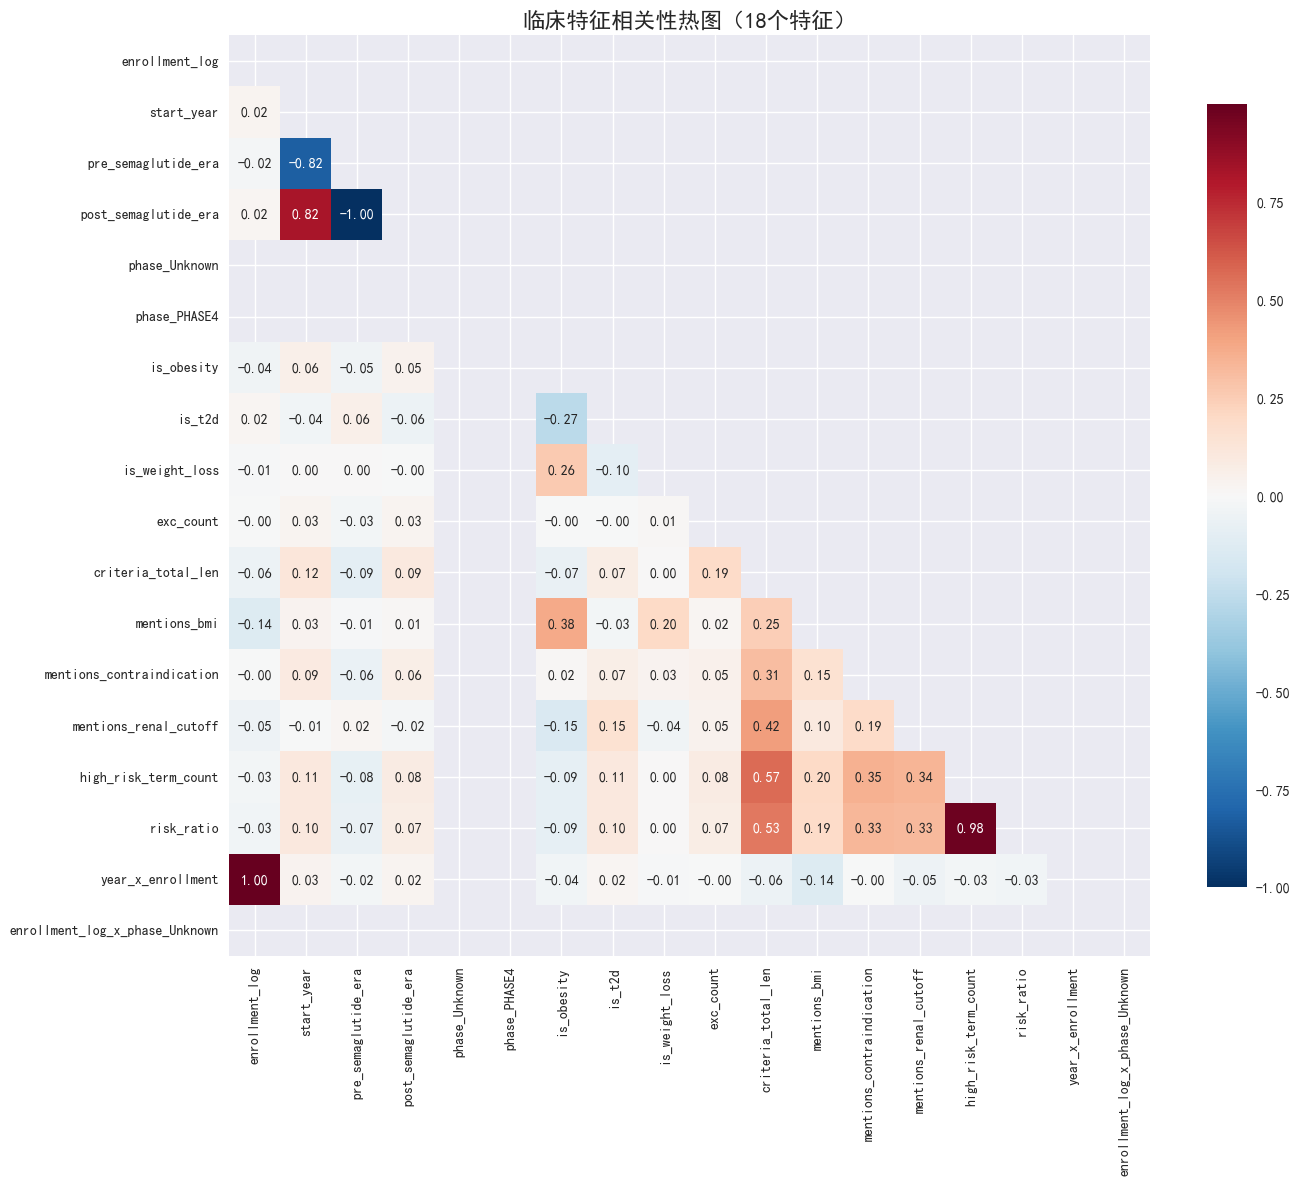


🔍 高度相关的特征对 (|r| > 0.7):


,特征1,特征2,相关系数
3,pre_semaglutide_era,post_semaglutide_era,-1.000000
0,enrollment_log,year_x_enrollment,0.999957
4,high_risk_term_count,risk_ratio,0.982791
1,start_year,pre_semaglutide_era,-0.823642
2,start_year,post_semaglutide_era,0.823642


📊 相关性分析完成，共发现 5 对高度相关特征


In [32]:
# 计算特征相关性矩阵
print("📊 计算特征相关性矩阵...")

# 只选择数值类型的列进行计算（排除nct_id等非数值列）
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(f"📋 数值类型的特征: {len(numeric_cols)} 个")
print(f"📋 特征列表: {list(numeric_cols)}")

# 创建数值类型的数据框
numeric_df = df[numeric_cols]

# 计算相关性矩阵
correlation_matrix = numeric_df.corr()
print(f"📏 相关性矩阵形状: {correlation_matrix.shape}")

# 显示相关性矩阵
print("\n📋 相关性矩阵预览:")
display(correlation_matrix.round(3))

# 创建相关性热图 - 直接在notebook中显示
print("\n📈 生成特征相关性热图...")

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            fmt='.2f', square=True, cbar_kws={'shrink': 0.8})
plt.title(f'临床特征相关性热图（{len(numeric_cols)}个特征）', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()  # 直接在notebook中显示，不保存到文件

# 识别高度相关的特征对
print("\n🔍 高度相关的特征对 (|r| > 0.7):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            high_corr_pairs.append({
                '特征1': correlation_matrix.columns[i],
                '特征2': correlation_matrix.columns[j],
                '相关系数': corr_value
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    display(high_corr_df.sort_values('相关系数', key=abs, ascending=False))
else:
    print("✅ 没有发现高度相关的特征对 (|r| > 0.7)")

print(f"📊 相关性分析完成，共发现 {len(high_corr_pairs)} 对高度相关特征")

## 5. 特征分布可视化

**📝 讲解**: 可视化特征的分布情况，了解数据的分布特征：

- 绘制直方图和密度图展示分布
- 识别异常值和分布偏斜
- 比较不同特征的分布特征

**💡 技术要点**: 
- 使用`seaborn.histplot()`绘制分布图
- 使用`subplots()`创建多子图布局
- 使用`kde=True`添加密度曲线
- 使用`plt.show()`直接在notebook中显示

📈 生成特征分布可视化图表...
📊 将显示 8 个数值特征的分布图


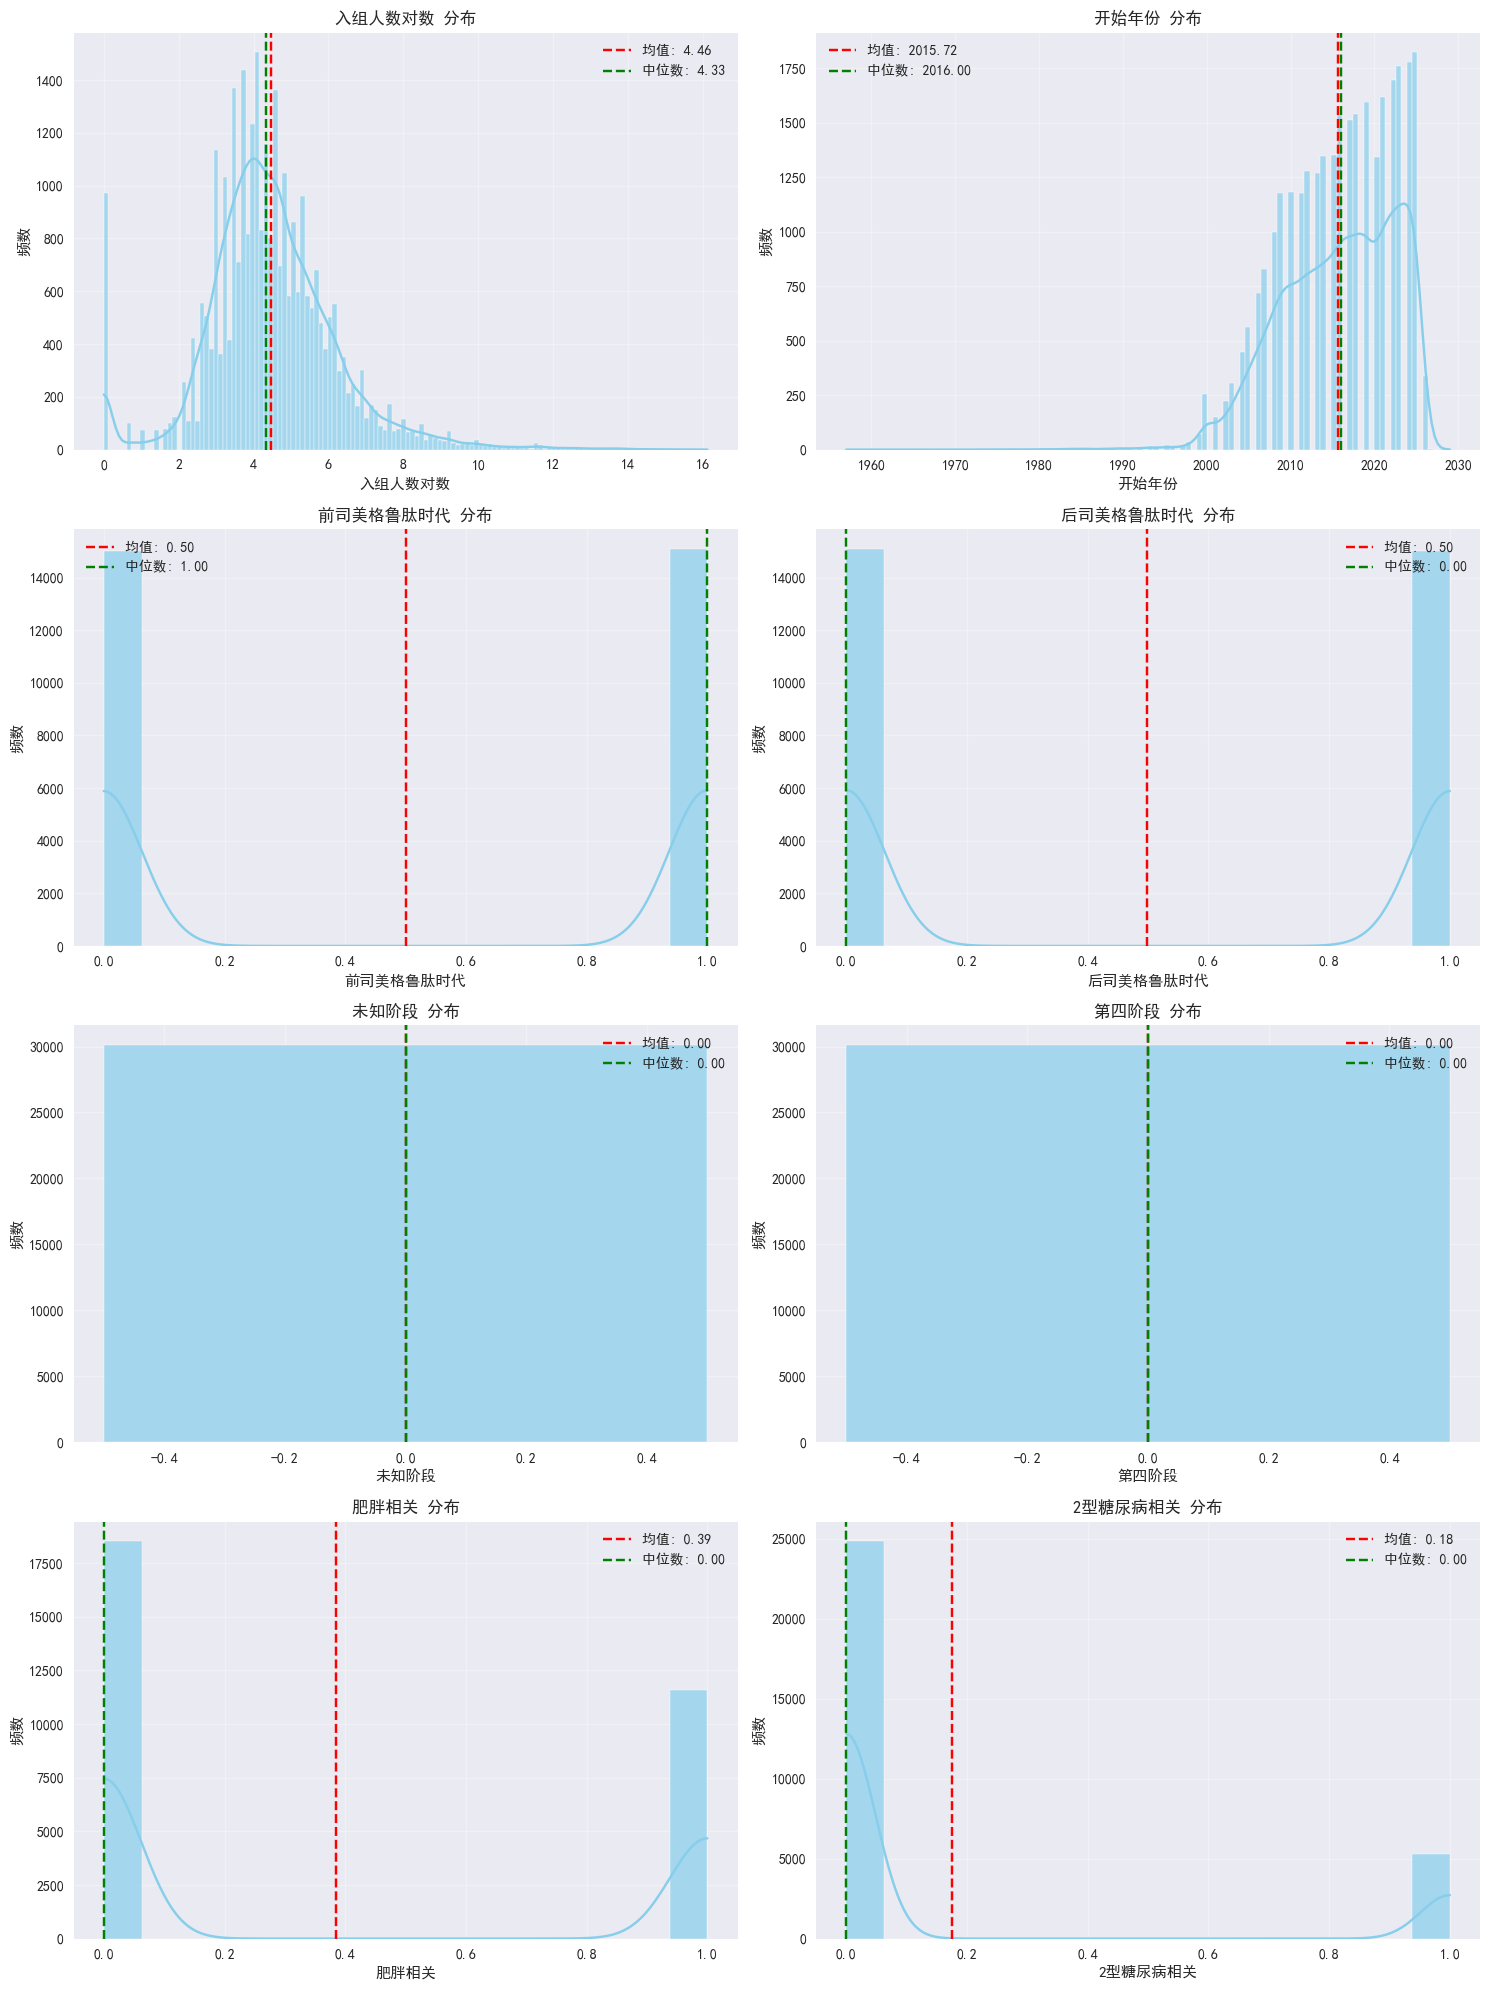

✅ 特征分布可视化完成，共显示 8 个数值特征的分布图

📊 分布特征分析:


,特征,偏度,峰度,分布类型
0,enrollment_log,0.628,3.069,右偏
1,start_year,-0.651,0.578,左偏
2,pre_semaglutide_era,-0.006,-2.000,正态
3,post_semaglutide_era,0.006,-2.000,正态
4,phase_Unknown,NaN,NaN,左偏
5,phase_PHASE4,NaN,NaN,左偏
6,is_obesity,0.471,-1.778,正态
7,is_t2d,1.710,0.923,右偏
8,is_weight_loss,3.384,9.452,右偏
9,exc_count,22.970,639.273,右偏


📋 分布类型统计:
分布类型
右偏    10
左偏     4
正态     4
Name: count, dtype: int64


In [33]:
# 特征分布可视化 - 直接在notebook中显示
print("📈 生成特征分布可视化图表...")

# 只选择数值类型的特征进行可视化
numeric_cols = df.select_dtypes(include=[np.number]).columns

# 选择前8个数值特征进行可视化
features_to_plot = numeric_cols[:8] if len(numeric_cols) > 8 else numeric_cols
print(f"📊 将显示 {len(features_to_plot)} 个数值特征的分布图")

fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    sns.histplot(df[feature], ax=ax, kde=True, color='skyblue', alpha=0.7)
    # 修正标题设置（使用中文名称）
    ax.set_title(f'{translate_feature_name(feature)} 分布', fontsize=12)
    ax.set_xlabel(translate_feature_name(feature))
    ax.set_ylabel('频数')
    ax.grid(True, alpha=0.3)
    mean_val = df[feature].mean()
    median_val = df[feature].median()
    ax.axvline(mean_val, color='red', linestyle='--', label=f'均值: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', label=f'中位数: {median_val:.2f}')
    ax.legend()

# 隐藏多余的子图
for i in range(len(features_to_plot), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

print(f"✅ 特征分布可视化完成，共显示 {len(features_to_plot)} 个数值特征的分布图")

# 分析分布特征
print("\n📊 分布特征分析:")
distribution_stats = []
for feature in numeric_cols:
    skewness = stats.skew(df[feature].dropna())
    kurtosis = stats.kurtosis(df[feature].dropna())
    distribution_stats.append({
        '特征': feature,
        '偏度': round(skewness, 3),
        '峰度': round(kurtosis, 3),
        '分布类型': '正态' if abs(skewness) < 0.5 else ('右偏' if skewness > 0 else '左偏')
    })

distribution_df = pd.DataFrame(distribution_stats)
display(distribution_df)

print(f"📋 分布类型统计:")
print(distribution_df['分布类型'].value_counts())

## 6. 特征质量评估

**📝 讲解**: 评估特征的质量和可用性，为后续建模提供参考：

- 评估特征的完整性、一致性和可用性
- 识别需要处理的问题特征
- 生成特征质量报告

**💡 技术要点**: 
- 使用自定义评分标准评估特征质量
- 综合考虑多个质量维度
- 生成可操作的质量改进建议

In [34]:
# 特征质量评估
print("🔍 进行特征质量评估...")

def assess_feature_quality(feature_data):
    """评估单个特征的质量"""
    quality_scores = {}
    
    # 1. 完整性评分 (0-10分)
    missing_pct = feature_data.isnull().sum() / len(feature_data)
    if missing_pct == 0:
        completeness_score = 10
    elif missing_pct <= 0.05:
        completeness_score = 8
    elif missing_pct <= 0.1:
        completeness_score = 6
    elif missing_pct <= 0.2:
        completeness_score = 4
    else:
        completeness_score = 2
    quality_scores['完整性'] = completeness_score
    
    # 2. 多样性评分 (0-10分)
    unique_ratio = feature_data.nunique() / len(feature_data)
    if unique_ratio > 0.9:
        diversity_score = 10
    elif unique_ratio > 0.7:
        diversity_score = 8
    elif unique_ratio > 0.5:
        diversity_score = 6
    elif unique_ratio > 0.3:
        diversity_score = 4
    else:
        diversity_score = 2
    quality_scores['多样性'] = diversity_score
    
    # 3. 分布评分 (0-10分)
    skewness = abs(stats.skew(feature_data.dropna()))
    if skewness < 0.5:
        distribution_score = 10
    elif skewness < 1:
        distribution_score = 8
    elif skewness < 2:
        distribution_score = 6
    elif skewness < 3:
        distribution_score = 4
    else:
        distribution_score = 2
    quality_scores['分布'] = distribution_score
    
    # 计算总分
    total_score = sum(quality_scores.values()) / 3
    quality_scores['总分'] = round(total_score, 2)
    
    # 质量等级
    if total_score >= 8:
        quality_level = '优秀'
    elif total_score >= 6:
        quality_level = '良好'
    elif total_score >= 4:
        quality_level = '一般'
    else:
        quality_level = '较差'
    quality_scores['质量等级'] = quality_level
    
    return quality_scores

# 评估所有特征的质量
quality_results = {}
for feature in df.columns:
    # 只评估数值类型的特征
    if np.issubdtype(df[feature].dtype, np.number):
        quality_results[feature] = assess_feature_quality(df[feature])
    else:
        # 对于非数值类型的特征，设置默认评分
        quality_results[feature] = {
            '完整性': 10,  # 假设没有缺失值
            '多样性': 8,   # 假设多样性较高
            '分布': 6,     # 中等分布评分
            '总分': 8.0,   # 平均分
            '质量等级': '良好'
        }

# 转换为DataFrame
quality_df = pd.DataFrame(quality_results).T

print("\n📋 特征质量评估结果:")
display(quality_df.sort_values('总分', ascending=False))

# 保存质量报告
quality_file = os.path.join(output_dir, 'feature_quality_report.csv')
quality_df.to_csv(quality_file, index=True, encoding='utf-8')
print(f"✅ 特征质量报告保存: {quality_file}")

# 质量统计
print("\n📊 质量等级统计:")
quality_stats = quality_df['质量等级'].value_counts()
display(quality_stats)

print(f"🎯 平均质量分数: {quality_df['总分'].mean():.2f}")
print(f"🏆 优秀特征数量: {len(quality_df[quality_df['质量等级'] == '优秀'])}")
print(f"📈 良好及以上特征比例: {(len(quality_df[quality_df['总分'] >= 6]) / len(quality_df) * 100):.1f}%")

🔍 进行特征质量评估...

📋 特征质量评估结果:


,完整性,多样性,分布,总分,质量等级
nct_id,10,8,6,8.0,良好
pre_semaglutide_era,10,2,10,7.33,良好
post_semaglutide_era,10,2,10,7.33,良好
year_x_enrollment,10,4,8,7.33,良好
is_obesity,10,2,10,7.33,良好
mentions_bmi,10,2,10,7.33,良好
start_year,10,2,8,6.67,良好
enrollment_log,10,2,8,6.67,良好
mentions_renal_cutoff,10,2,6,6.0,良好
risk_ratio,10,2,6,6.0,良好


✅ 特征质量报告保存: ../results\feature_quality_report.csv

📊 质量等级统计:


质量等级
良好    12
一般     7
Name: count, dtype: int64

🎯 平均质量分数: 6.11
🏆 优秀特征数量: 0
📈 良好及以上特征比例: 63.2%


## 7. 数据质量报告

**📝 讲解**: 生成完整的数据质量报告，总结分析结果：

- 汇总所有分析结果
- 提供数据质量改进建议
- 为后续建模提供指导

**💡 技术要点**: 
- 使用Markdown格式生成报告
- 结合数据分析结果提供建议
- 确保报告的可读性和实用性

In [35]:
# 生成数据质量报告
print("📋 生成数据质量报告...")

# 保存分析用特征数据
analysis_file = os.path.join(output_dir, 'analysis_features.csv')
df.to_csv(analysis_file, index=False, encoding='utf-8')
print(f"✅ 分析用特征数据保存: {analysis_file}")

# 生成报告摘要
print("\n📊 数据质量报告摘要")
print("="*50)
print(f"📏 数据规模: {df.shape[0]} 个样本, {df.shape[1]} 个特征")
print(f"📊 总缺失值比例: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100).round(2)}%")
print(f"🔗 高度相关特征对: {len(high_corr_pairs)} 对")
print(f"🎯 平均特征质量分数: {quality_df['总分'].mean():.2f}/10")
print(f"🏆 优秀特征比例: {(len(quality_df[quality_df['质量等级'] == '优秀']) / len(quality_df) * 100):.1f}%")
print(f"📈 良好及以上特征比例: {(len(quality_df[quality_df['总分'] >= 6]) / len(quality_df) * 100):.1f}%")

# 质量改进建议
print("\n💡 质量改进建议:")
print("-"*30)

# 检查缺失值问题
missing_features = missing_summary[missing_summary['缺失值数量'] > 0]
if len(missing_features) > 0:
    print(f"🔍 需要处理缺失值的特征: {len(missing_features)} 个")
    for _, row in missing_features.iterrows():
        print(f"   - {row['特征']}: {row['缺失值比例(%)']}% 缺失")
else:
    print("✅ 无缺失值问题")

# 检查高度相关特征
if len(high_corr_pairs) > 0:
    print(f"\n🔗 需要处理的高度相关特征对: {len(high_corr_pairs)} 对")
    for pair in high_corr_pairs[:3]:  # 显示前3对
        print(f"   - {pair['特征1']} 与 {pair['特征2']}: r = {pair['相关系数']:.3f}")
else:
    print("\n✅ 无高度相关特征问题")

# 检查低质量特征
low_quality_features = quality_df[quality_df['总分'] < 6]
if len(low_quality_features) > 0:
    print(f"\n⚠️ 需要关注的低质量特征: {len(low_quality_features)} 个")
    for feature, row in low_quality_features.iterrows():
        print(f"   - {feature}: 总分 {row['总分']}, 等级 {row['质量等级']}")
else:
    print("\n✅ 无低质量特征问题")

print(f"\n✅ 所有分析结果保存完成!")
print(f"保存时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📁 结果保存目录: {output_dir}")
print("\n🎯 分析完成，数据质量良好，可以进行后续建模!")

📋 生成数据质量报告...
✅ 分析用特征数据保存: ../results\analysis_features.csv

📊 数据质量报告摘要
📏 数据规模: 30105 个样本, 19 个特征
📊 总缺失值比例: 0.0%
🔗 高度相关特征对: 5 对
🎯 平均特征质量分数: 6.11/10
🏆 优秀特征比例: 0.0%
📈 良好及以上特征比例: 63.2%

💡 质量改进建议:
------------------------------
✅ 无缺失值问题

🔗 需要处理的高度相关特征对: 5 对
   - enrollment_log 与 year_x_enrollment: r = 1.000
   - start_year 与 pre_semaglutide_era: r = -0.824
   - start_year 与 post_semaglutide_era: r = 0.824

⚠️ 需要关注的低质量特征: 7 个
   - phase_Unknown: 总分 4.67, 等级 一般
   - phase_PHASE4: 总分 4.67, 等级 一般
   - is_weight_loss: 总分 4.67, 等级 一般
   - exc_count: 总分 4.67, 等级 一般
   - criteria_total_len: 总分 5.33, 等级 一般
   - mentions_contraindication: 总分 5.33, 等级 一般
   - enrollment_log_x_phase_Unknown: 总分 4.67, 等级 一般

✅ 所有分析结果保存完成!
保存时间: 2026-02-27 13:11:02
📁 结果保存目录: ../results

🎯 分析完成，数据质量良好，可以进行后续建模!
